### STRATEGY

**ENTRY:** If candle closes as green and ichimoku conversion line crosses above base line, wait and *BUY* at the close of second candle.


**TAKE PROFIT:** Sell at the first closing where profit is more than 0.01%


**STOP LOSS:** You have the option to put a stop loss when ichimoku conversion line crosses below base line.


**Time frame:** 15 Minute


In [1]:
import pandas as pd
import numpy as np
from ta.trend import IchimokuIndicator
from binance.client import Client
from datetime import datetime as dt
from matplotlib import pyplot as plt 
plt.style.use('seaborn')

In [2]:
def get_data(symbol, start_date, end_date):
    interval = Client.KLINE_INTERVAL_15MINUTE
    API_KEY='YOUR_API_KEYS'
    API_SECRET='YOUR_SECRET_KEYS'

    client = Client(API_KEY,API_SECRET)
    candlesticks = client.get_historical_klines(symbol, interval, start_date, end_date)

    df = pd.DataFrame(candlesticks)
    df=df[[0,1,2,3,4]]
    df[0] = pd.to_datetime(df[0]/1000,unit='s')
    df[[1,2,3,4]] = df[[1,2,3,4]].apply(pd.to_numeric)
    
    ichimoku = IchimokuIndicator(high=df[2], low=df[3], window1=9, window2=26, window3=52)
    ichimoku_base = ichimoku.ichimoku_base_line()
    ichimoku_conversion = ichimoku.ichimoku_conversion_line()

    df['ichimoku_base'] = ichimoku_base
    df['ichimoku_conversion'] = ichimoku_conversion
    df = df[df['ichimoku_base'].notna()]
    return df
    

In [3]:
df = get_data('BTCUSDT', '1 Sep, 2017','31 Mar, 2022')

In [4]:
def backtest(df,min_take_profit, stop_loss):
    position = False
    profit = []
    exit_date = []
    entry_date = []
    
    # Get Entry Points 
    df["position"] = np.nan
    df.loc[(df[4].shift(1) > df[1].shift(1)) & 
       (df["ichimoku_base"] < df["ichimoku_conversion"])&
       (df["ichimoku_base"].shift(1) < df["ichimoku_conversion"].shift(1))&
       (df["ichimoku_base"].shift(2) > df["ichimoku_conversion"].shift(2)), "position"] = 1

    for row in df.itertuples(index=False):
        if row.position ==1 and not position:
            entry_price = row[4]
            position = True

        elif position:
            if (row[4] - entry_price) * 100 / entry_price > min_take_profit or (stop_loss and row.ichimoku_base > row.ichimoku_conversion):
                profit.append((row[4] - entry_price) * 100 / entry_price)
                exit_date.append(row[0])
                position = False
    
    total_profit = sum(profit)
    profit=np.array(profit)
    winners = len(profit[profit > 0])
    losers = len(profit[profit < 0])
    cumulative_returns = np.add.accumulate(profit)
    win_rate = round(winners*100/(winners+losers),2)
    return total_profit, win_rate, winners, losers, cumulative_returns, exit_date


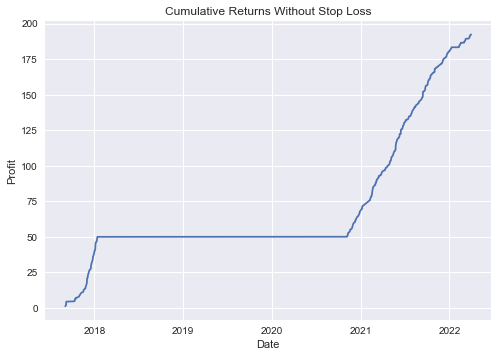

Total Profit: 192.36%
Winners: 572
Losers:0
Win Rate: 100.0%


In [5]:
# Without Stop Loss, take minimum 0.01% Profit
total_profit, win_rate, winners, losers, cumulative_returns, exit_date = backtest(df,0.01,False)

# Plot
plt.title(f"Cumulative Returns Without Stop Loss") 
plt.xlabel("Date")
plt.ylabel("Profit") 
plt.rcParams["figure.figsize"] = [11,6]
text = f'Total Profit: {round(total_profit,2)}%\nWinners: {winners}\nLosers:{losers}\nWin Rate: {round(winners*100/(winners+losers),2)}%'
plt.plot(exit_date,cumulative_returns)
plt.show()
print(text)

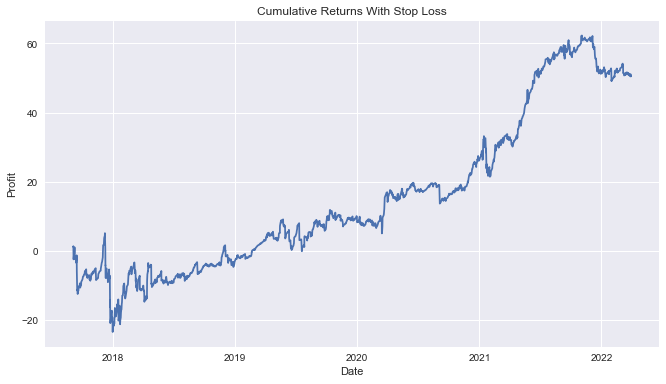

Total Profit: 50.51%
Winners: 1722
Losers:422
Win Rate: 80.32%


In [6]:
# With Stop Loss, take minimum 0.01% Profit
total_profit2, win_rate2, winners2, losers2, cumulative_returns2, exit_date2 = backtest(df,0.01,True)

# Plot
plt.title(f"Cumulative Returns With Stop Loss") 
plt.xlabel("Date")
plt.ylabel("Profit") 
plt.rcParams["figure.figsize"] = [11,6]
text = f'Total Profit: {round(total_profit2,2)}%\nWinners: {winners2}\nLosers:{losers2}\nWin Rate: {round(win_rate2,2)}%'
plt.plot(exit_date2,cumulative_returns2)
plt.show()
print(text)